In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
import pickle
from IPython.display import Image

# Load data

In [2]:
data_path = "../data/"
label_df = pd.read_csv(data_path + "labels.csv")
with open(data_path + 'outputs/convnext_tiny.pkl', 'rb') as f:
    results_img = pickle.load(f)
with open(data_path + 'outputs/ts_convnext_tiny.pkl', 'rb') as f:
    results_all = pickle.load(f)

In [3]:
split_column = 'farmer_id'
feature_unique = pd.Series(label_df[split_column].unique())
train_split, val_split, test_split = np.split(feature_unique.sample(frac=1, random_state=42), 
                                                  [int(0.8*len(feature_unique)), int((0.8 + 0.1)*len(feature_unique))])
test_csv = label_df[label_df[split_column].isin(test_split)]

/Users/flaviap/miniconda3/envs/hack4good/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [4]:
res = pd.DataFrame()
res['label'] = results_img["labels"]
res['img_probabilities'] = results_img["probabilities"][:,1]
res['img_predictions'] = results_img["predictions"]
res['idx'] = results_img["idx"]
res['all_probabilities'] = results_all["probabilities"][:,1]
res['all_predictions'] = results_all["predictions"]
res = res.set_index('idx')

In [5]:
df = test_csv.reset_index(drop=True)
df = df.merge(res, how='inner', left_index=True, right_index=True)

# Results

## Pure Image model

In [6]:
labels = df["label"]
probabilities = df["img_probabilities"]
predictions = df["img_predictions"]

##### Metrics

In [7]:
accuracy = balanced_accuracy_score(predictions, labels)
f1 = f1_score(predictions, labels)
precision = precision_score(predictions, labels)
recall = recall_score(predictions, labels)
accuracy, f1, precision, recall

(0.7899617543825151,
 0.7619047619047619,
 0.8534704370179949,
 0.6880829015544041)

##### Calibration plots

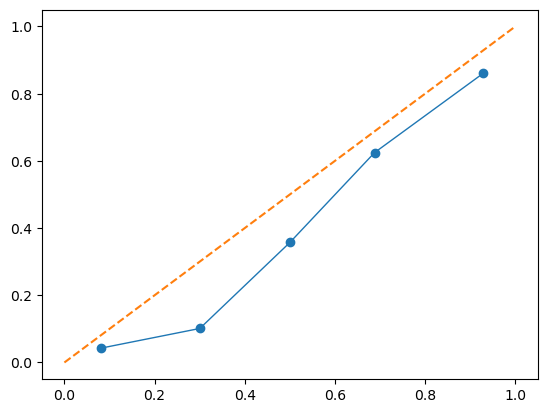

In [14]:
prob_true, prob_pred = calibration_curve(labels, probabilities)
plt.plot(prob_pred,
         prob_true, 
         marker='o', 
         linewidth=1, 
         label='model_name')
 
#Plot the Perfectly Calibrated by Adding the 45-degree line to the plot
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')

##### Confusion Matrix

Text(120.72222222222221, 0.5, 'True')

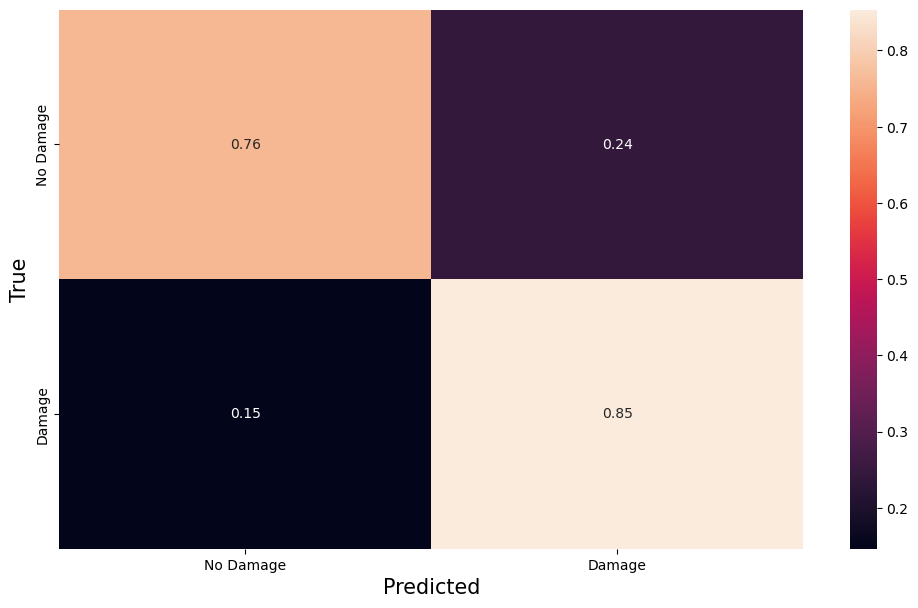

In [15]:
cf_matrix = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = ["No Damage","Damage"], columns = ["No Damage","Damage"])
fig, ax = plt.subplots(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('True', fontsize = 15)

## Multimodal model

In [8]:
labels = df["label"]
probabilities = df["all_probabilities"]
predictions = df["all_predictions"]

##### Metrics

In [9]:
accuracy = balanced_accuracy_score(predictions, labels)
f1 = f1_score(predictions, labels)
precision = precision_score(predictions, labels)
recall = recall_score(predictions, labels)
accuracy, f1, precision, recall

(0.7874745276486299,
 0.7566293459045375,
 0.8251928020565553,
 0.6985854189336235)

##### Calibration plots

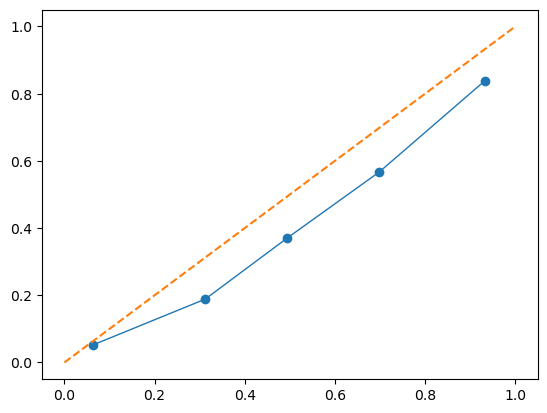

In [18]:
prob_true, prob_pred = calibration_curve(labels, probabilities)
plt.plot(prob_pred,
         prob_true, 
         marker='o', 
         linewidth=1, 
         label='model_name')
 
#Plot the Perfectly Calibrated by Adding the 45-degree line to the plot
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')

##### Confusion Matrix

Text(120.72222222222221, 0.5, 'True')

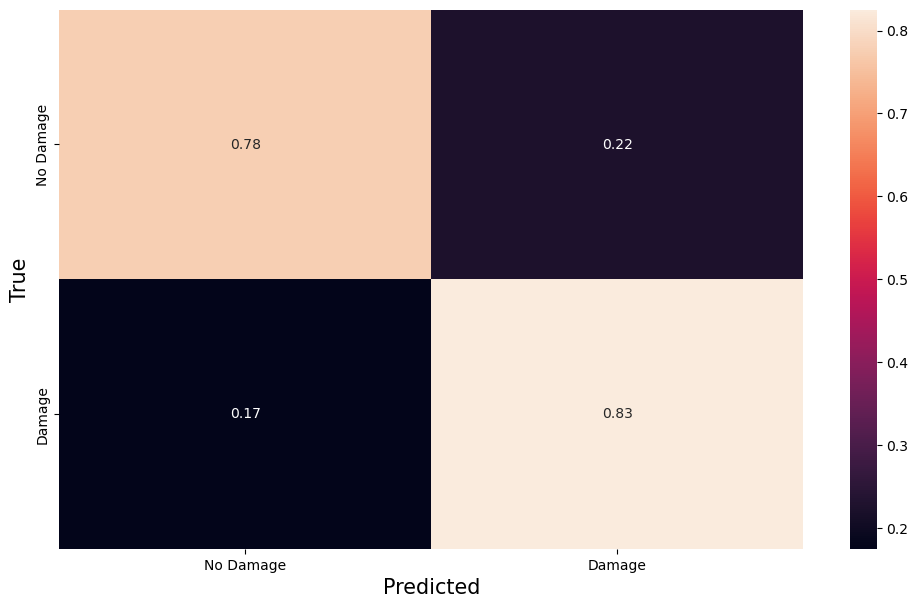

In [19]:
cf_matrix = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = ["No Damage","Damage"], columns = ["No Damage","Damage"])
fig, ax = plt.subplots(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('True', fontsize = 15)

# Best predictions

### Correctly predicts damage

In [ ]:
i=0
best = df[(df['img_probabilities'] > 0.95) & (df['label'] == 1)]
best.head()

In [ ]:
img_name = best.iloc[i, 0]
i += 1
img_path = data_path + "images/" + img_name
Image(filename=img_path)

### Correctly predicts no damage

In [ ]:
i=0
best = df[(df['img_probabilities'] < 0.05) & (df['label'] == 0)]
best.head()

In [ ]:
img_name = best.iloc[i, 0]
i += 1
img_path = data_path + "images/" + img_name
Image(filename=img_path)

# Worst predictions

### Incorrectly predicts damage

In [ ]:
i = 0
worst = df[(df['img_probabilities'] > 0.95) & (df['label'] == 0)]
worst.head()

In [ ]:
img_name = worst.iloc[i, 0]
i += 1
img_path = data_path + "images/" + img_name
Image(filename=img_path)

### Incorrectly predicts no damage

In [ ]:
i = 0
worst = df[(df['img_probabilities'] < 0.05) & (df['label'] == 1)]
worst.head()

In [ ]:
img_name = worst.iloc[i, 0]
i += 1
img_path = data_path + "images/" + img_name
Image(filename=img_path)